In [9]:
from PIL import Image, ImageDraw, ImageEnhance, ImageFont
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import cv2
import glob
import random
import ipykernel
import pathlib


give file locations

In [ ]:
# Replace with the path to the folder containing  training images
image_directory = r'C:\Users\Chris\Documents\Uni\Programm for AI\completed test\train\images'
#replace with the path to the folder containing notebook
script_dir = r"C:\Users\Chris\Documents\Uni\Programm for AI\completed test"

Split Images into Entropy Levels

In [6]:
def calculate_entropy(image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert("L")
    image_array = np.array(grayscale_image)
    histogram, _ = np.histogram(image_array, bins=256, range=(0, 255), density=True)
    entropy = -np.sum(histogram * np.log2(histogram + 1e-10))  # adding epsilon to avoid log(0)
    return entropy

# Function to filter out and print the paths of low entropy images
def filter_low_entropy_images(directory, threshold):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            entropy = calculate_entropy(file_path)
            if entropy < threshold:
                #print(f"Low entropy image found: {file_path}, Entropy: {entropy}")
                image = Image.open(file_path)
        except Exception as e:
            print(f"Could not process {file_path}: {e}")
def split_images_into_entropy_groups(directory, entropy_bins):
    # Create directories for the entropy groups if they don't exist
    for i in range(len(entropy_bins) - 1):
        os.makedirs(f'entropy_group_{i}', exist_ok=True)

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            entropy = calculate_entropy(file_path)
            # Assign the image to an entropy group
            for i in range(len(entropy_bins) - 1):
                if entropy_bins[i] <= entropy < entropy_bins[i + 1]:
                    # Copy the image to the corresponding directory
                    shutil.copy(file_path, f'entropy_group_{i}')
                    break
        except Exception as e:
            print(f"Could not process {file_path}: {e}")

#entropy bins
entropy_bins = [0, 2, 3, 3.5, 4, float('inf')] 

# Run the function
split_images_into_entropy_groups(image_directory, entropy_bins)

# test entropy bounds
#entropy_threshold = 4  # Adjust this threshold based on your dataset

# Run the filter function
#filter_low_entropy_images(image_directory, entropy_threshold)

Sub-Split into Brightness Levels

In [17]:
def calculate_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return np.mean(hsv[:,:,2])

def categorize_images(path):
    categories = ['very_dark_brightness', 'dark_brightness', 'extra_low_brightness', 
                  'very_low_brightness', 'low_brightness', 'medium_brightness', 'high_brightness']

    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(path, filename))
            brightness = calculate_brightness(image)
            if brightness < 5:
                category = categories[0]
            elif brightness < 10:
                category = categories[1]
            elif brightness < 21:
                category = categories[2]
            elif brightness < 42:
                category = categories[3]
            elif brightness < 85:
                category = categories[4]
            elif brightness < 170:
                category = categories[5]
            else:
                category = categories[6]

            new_dir = os.path.join(path, category)
            if not os.path.exists(new_dir):
                os.makedirs(new_dir)

            shutil.copy(os.path.join(path, filename), os.path.join(new_dir, filename))


for i in range(5):
    entropy_group_dir = os.path.join(script_dir, f'entropy_group_{i}')
    if os.path.exists(entropy_group_dir):
        categorize_images(entropy_group_dir)

Enhanse Images based on Entropy-Brightness Level

In [18]:
# Function to increase brightness and contrast
def adjust_brightness_contrast(input_image_path, output_image_path, brightness=1, contrast=1):
    # Open the image file
    img = Image.open(input_image_path)

    # Enhance brightness
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)

    # Enhance contrast
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)

    # Save the edited image
    img.save(output_image_path)
    img.close()

# Define the directory path
base_dir_path = script_dir
print(base_dir_path)

# Define the brightness and contrast values for each entropy group folder
entropy_group_values = { #checked and cleared
    'entropy_group_0': { 
        "dark_brightness": (1.25, 1.5), #checked and cleared
        "extra_low_brightness": (1, 1.25), #checked and cleared
        "high_brightness": (0.75, 1.5), #does not exist
        "low_brightness": (1, 1.25), #does not exist
        "medium_brightness": (1, 1), #does not exist
        "very_dark_brightness": (2.25, 2.5), #checked and cleared
        "very_low_brightness": (1, 0.75)  
    },

    'entropy_group_1': { 
        "dark_brightness": (1.75, 1.75), #checked and cleared
        "extra_low_brightness": (1.3, 0.75), #checked and cleared
        "high_brightness": (0.75, 1.5), #does not exist
        "low_brightness": (0.75, 1.5), #checked and cleared
        "medium_brightness": (1, 1), #does not exist
        "very_dark_brightness": (2.25, 2.5), #still to dark, cannot justify increase due to fidelity loss
        "very_low_brightness": (1, 0.75) #checked and cleared
    },

    'entropy_group_2': { #checked and cleared
        "dark_brightness": (2, 2), #checked and cleared
        "extra_low_brightness": (1.25, 1.25), #checked and cleared
        "high_brightness": (0.75, 1.5), #checked and cleared
        "low_brightness": (1, 1.25), #checked and cleared
        "medium_brightness": (1, 1), #checked and cleared
        "very_dark_brightness": (2.25, 2.5), #checked and cleared
        "very_low_brightness": (1, 1.25) #checked and cleared
    },

    'entropy_group_3': { #checked and cleared
        "dark_brightness": (2, 2), #checked and cleared
        "extra_low_brightness": (1.5, 1.25), #checked and cleared
        "high_brightness": (0.75, 1.75), #checked and cleared
        "low_brightness": (1, 1.25), #checked and cleared
        "medium_brightness": (1, 1), #checked and cleared
        "very_dark_brightness": (3, 2),  #still to dark, cannot justify increase due to fidelity loss
        "very_low_brightness": (1, 1.25) #checked and cleared
    },

    'entropy_group_4': { 
        "dark_brightness": (2, 2),  #checked and cleared
        "extra_low_brightness": (1.5, 1.25), #checked and cleared
        "high_brightness": (0.75, 2), #checked and cleared
        "low_brightness": (1, 1.25), #checked and cleared
        "medium_brightness": (1, 1.15), #checked and cleared
        "very_dark_brightness": (2.25, 2.5), #does not exist
        "very_low_brightness": (1, 1.25) #checked and cleared
    }
}

# Loop through each entropy group folder in the dictionary
for entropy_group_folder, folder_values in entropy_group_values.items():
    # Define the directory path for the current entropy group folder
    dir_path = os.path.join(base_dir_path, entropy_group_folder)

    # Loop through each brightness folder in the dictionary
    for folder, (brightness_value, contrast_value) in folder_values.items():
        # Define the input and output paths
        input_dir_path = os.path.join(dir_path, folder)
        output_dir_path = os.path.join(input_dir_path, 'edited_images')

        # Remove the directory if it exists
        if os.path.exists(output_dir_path):
            shutil.rmtree(output_dir_path)

        # Create a new directory for the edited images
        os.makedirs(output_dir_path, exist_ok=True)

        # Loop through each file in the directory
        for filename in os.listdir(input_dir_path):
            # Check if the file is an image
            if filename.endswith('.jpg') or filename.endswith('.png'):
                # Define the input and output paths
                input_image_path = os.path.join(input_dir_path, filename)
                output_image_path = os.path.join(output_dir_path, filename)

                # Adjust brightness and contrast of the image
                adjust_brightness_contrast(input_image_path, output_image_path, brightness=brightness_value, contrast=contrast_value)

C:\Users\Chris\Documents\Uni\Programm for AI\completed test


Compare non enhansed vs enhansed

In [19]:
def compare_images(base_dir_path, entropy_group_values):
    for entropy_group_folder, folder_values in entropy_group_values.items():
        dir_path = os.path.join(base_dir_path, entropy_group_folder)

        for folder, _ in folder_values.items():
            input_dir_path = os.path.join(dir_path, folder)
            output_dir_path = os.path.join(input_dir_path, 'edited_images')

            # Get the list of image files
            image_files = [f for f in os.listdir(input_dir_path) if f.endswith('.jpg') or f.endswith('.png')]

            if not image_files:
                print(f'No images in folder {input_dir_path}')
                continue

            # Select 5 random image files
            selected_files = random.sample(image_files, min(5, len(image_files)))

            if len(selected_files) < 5:
                print(f'No more images in folder {input_dir_path}')

            for filename in selected_files:
                input_image_path = os.path.join(input_dir_path, filename)
                output_image_path = os.path.join(output_dir_path, filename)

                # Open the original and transformed images
                original_img = Image.open(input_image_path)
                transformed_img = Image.open(output_image_path)

                # Create a new figure
                fig, ax = plt.subplots(1, 2)

                # Print the file name and its entropy/light folder
                print(f'Original - {input_image_path}')
                print(f'Transformed - {entropy_group_folder} - {folder} - {filename}')

                # Turn off axis
                ax[0].axis('off')
                ax[1].axis('off')

                # Display the images
                ax[0].imshow(original_img)
                ax[1].imshow(transformed_img)

                # Show the figure
                plt.show()

                # Close the images
                original_img.close()
                transformed_img.close()

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\dark_brightness\image1_1130_png.rf.bef52cff26e4aac5f94604fadc910bd3.jpg
Transformed - entropy_group_0 - dark_brightness - image1_1130_png.rf.bef52cff26e4aac5f94604fadc910bd3.jpg


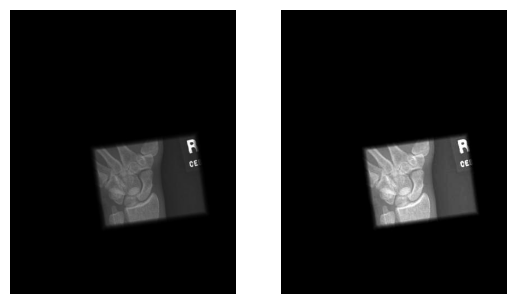

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\dark_brightness\image1_487_png.rf.17e6b6d64daf623c2462d266df535869.jpg
Transformed - entropy_group_0 - dark_brightness - image1_487_png.rf.17e6b6d64daf623c2462d266df535869.jpg


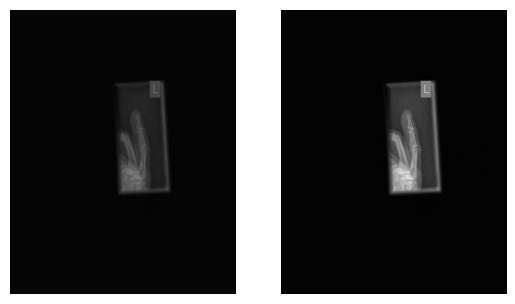

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\dark_brightness\image1_788_png.rf.2343ea1d06fe5e575fdc174137de3899.jpg
Transformed - entropy_group_0 - dark_brightness - image1_788_png.rf.2343ea1d06fe5e575fdc174137de3899.jpg


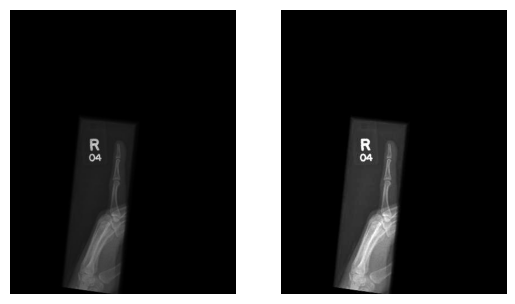

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\dark_brightness\image1_77_png.rf.ffc78fd2dd54a787faf573ae7446593a.jpg
Transformed - entropy_group_0 - dark_brightness - image1_77_png.rf.ffc78fd2dd54a787faf573ae7446593a.jpg


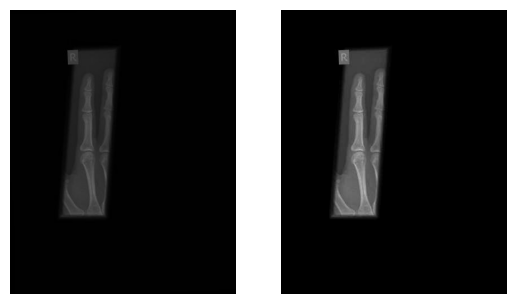

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\dark_brightness\image1_416_png.rf.7fbff7437e069421ea51e2620c2dc8db.jpg
Transformed - entropy_group_0 - dark_brightness - image1_416_png.rf.7fbff7437e069421ea51e2620c2dc8db.jpg


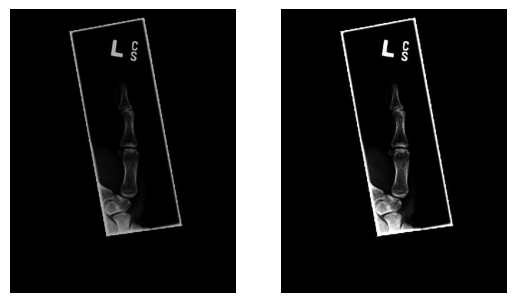

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\extra_low_brightness\image1_194_png.rf.b91e5c5e53b21645e8f307fd05eca3e9.jpg
Transformed - entropy_group_0 - extra_low_brightness - image1_194_png.rf.b91e5c5e53b21645e8f307fd05eca3e9.jpg


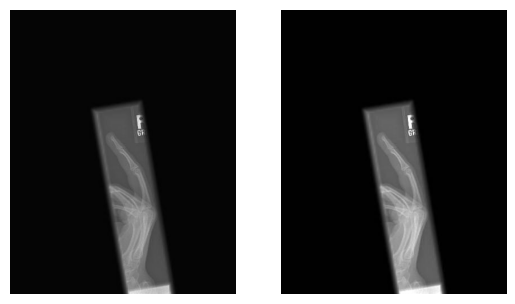

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\extra_low_brightness\image1_306_png.rf.e4a7c0512a9c2403f468089cd77b8bd2.jpg
Transformed - entropy_group_0 - extra_low_brightness - image1_306_png.rf.e4a7c0512a9c2403f468089cd77b8bd2.jpg


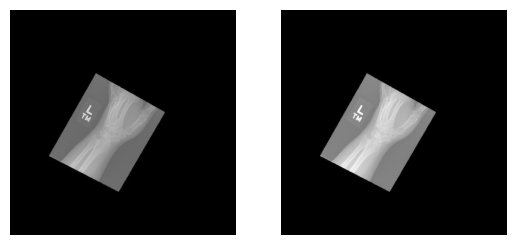

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\extra_low_brightness\image1_773_png.rf.57de4c6ab164ebbdcd49f444b58cc513.jpg
Transformed - entropy_group_0 - extra_low_brightness - image1_773_png.rf.57de4c6ab164ebbdcd49f444b58cc513.jpg


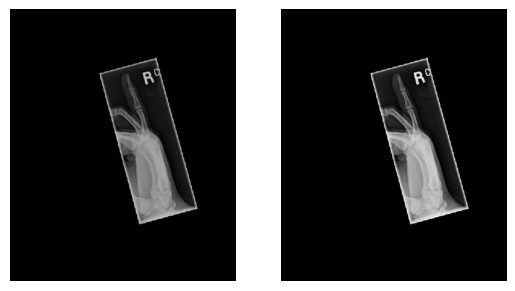

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\extra_low_brightness\image1_788_png.rf.46c957a23d7486321e267481ce82fb72.jpg
Transformed - entropy_group_0 - extra_low_brightness - image1_788_png.rf.46c957a23d7486321e267481ce82fb72.jpg


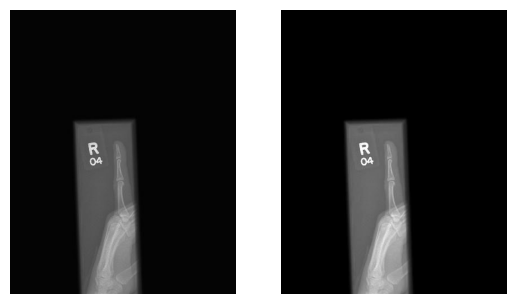

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\extra_low_brightness\image1_773_png.rf.4822ae8f774d60e4cf30be96dcb0ae3f.jpg
Transformed - entropy_group_0 - extra_low_brightness - image1_773_png.rf.4822ae8f774d60e4cf30be96dcb0ae3f.jpg


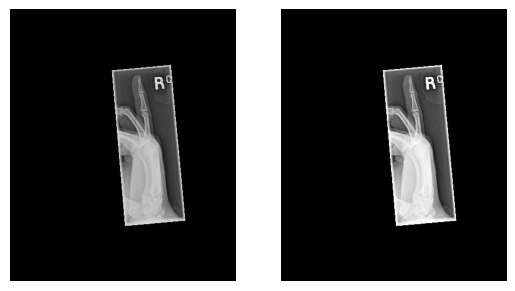

No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\high_brightness
No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\low_brightness
No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\medium_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_dark_brightness\image1_53_png.rf.6f40980c7c56541ff013daea67a346c7.jpg
Transformed - entropy_group_0 - very_dark_brightness - image1_53_png.rf.6f40980c7c56541ff013daea67a346c7.jpg


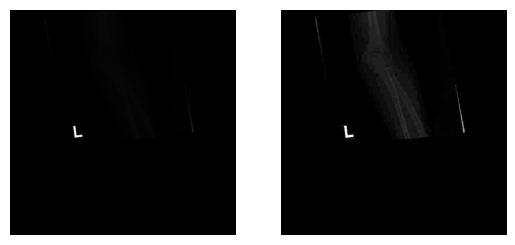

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_dark_brightness\image1_247_png.rf.679f7a0d51cd5e662922853814bea590.jpg
Transformed - entropy_group_0 - very_dark_brightness - image1_247_png.rf.679f7a0d51cd5e662922853814bea590.jpg


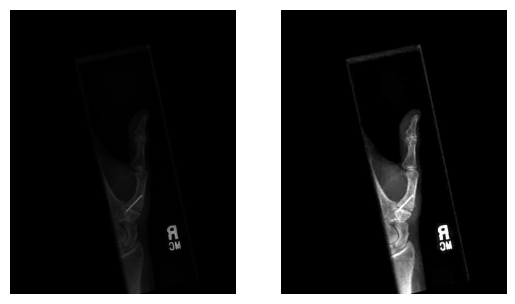

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_dark_brightness\image1_474_png.rf.bd00013e5bb425e25c2a281356d760b7.jpg
Transformed - entropy_group_0 - very_dark_brightness - image1_474_png.rf.bd00013e5bb425e25c2a281356d760b7.jpg


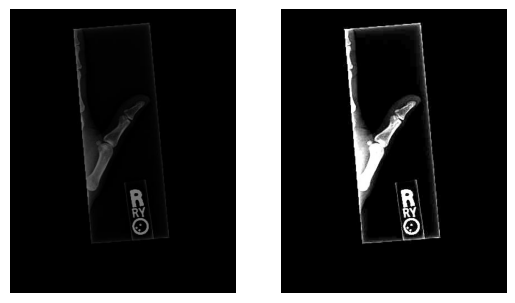

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_dark_brightness\image1_591_png.rf.fc3e44c563ce90fbd2c3472a042ce157.jpg
Transformed - entropy_group_0 - very_dark_brightness - image1_591_png.rf.fc3e44c563ce90fbd2c3472a042ce157.jpg


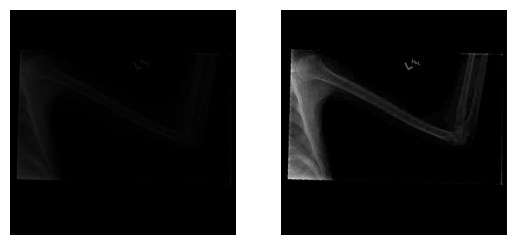

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_dark_brightness\image1_19_png.rf.bf54a53b761fc76dd5d627b8bcfe8160.jpg
Transformed - entropy_group_0 - very_dark_brightness - image1_19_png.rf.bf54a53b761fc76dd5d627b8bcfe8160.jpg


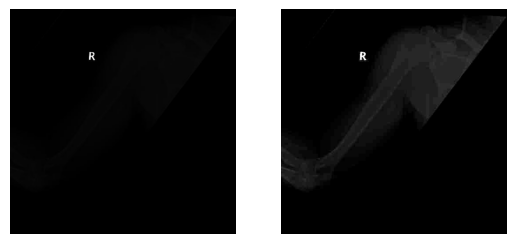

No more images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_low_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_0\very_low_brightness\image1_306_png.rf.cf5628c2bfcb56dfcb1d2a91155f4461.jpg
Transformed - entropy_group_0 - very_low_brightness - image1_306_png.rf.cf5628c2bfcb56dfcb1d2a91155f4461.jpg


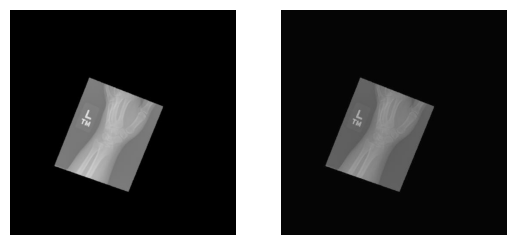

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\dark_brightness\image2_1774_png.rf.28e5ec5174f1f1d2b4d2ccc02fbd87c8.jpg
Transformed - entropy_group_1 - dark_brightness - image2_1774_png.rf.28e5ec5174f1f1d2b4d2ccc02fbd87c8.jpg


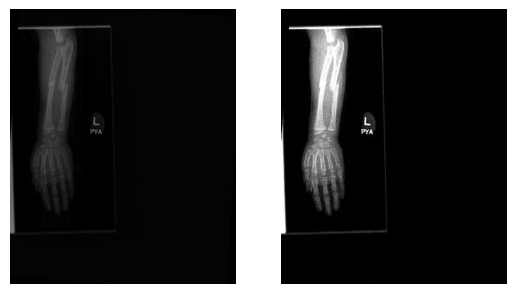

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\dark_brightness\image1_150_png.rf.8c21b8c0515a6cae0771d76b6b84a797.jpg
Transformed - entropy_group_1 - dark_brightness - image1_150_png.rf.8c21b8c0515a6cae0771d76b6b84a797.jpg


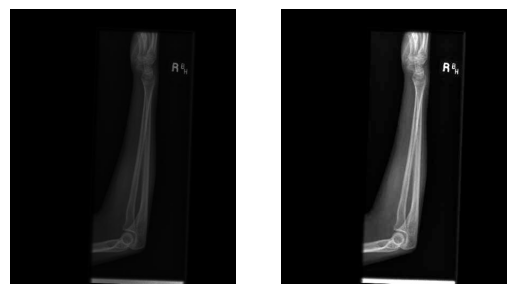

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\dark_brightness\image1_1893_png.rf.4a1dd03fbef480e2fe9959e31100d268.jpg
Transformed - entropy_group_1 - dark_brightness - image1_1893_png.rf.4a1dd03fbef480e2fe9959e31100d268.jpg


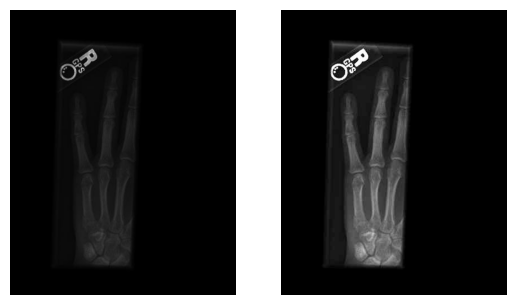

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\dark_brightness\image2_738_png.rf.102552b8e2ede036974564ea13c50e84.jpg
Transformed - entropy_group_1 - dark_brightness - image2_738_png.rf.102552b8e2ede036974564ea13c50e84.jpg


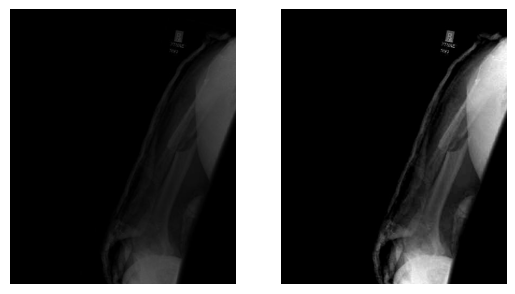

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\dark_brightness\image1_672_png.rf.addbebd99371bfe91f11b084a0da0d83.jpg
Transformed - entropy_group_1 - dark_brightness - image1_672_png.rf.addbebd99371bfe91f11b084a0da0d83.jpg


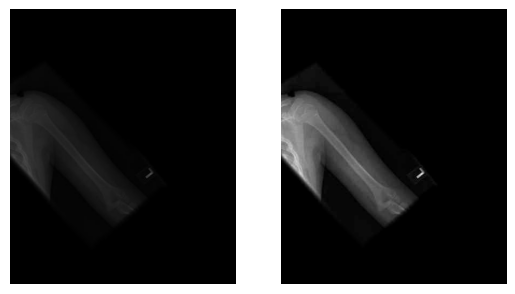

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\extra_low_brightness\image1_432_png.rf.b8c8b545286055f3000e4172c35337dc.jpg
Transformed - entropy_group_1 - extra_low_brightness - image1_432_png.rf.b8c8b545286055f3000e4172c35337dc.jpg


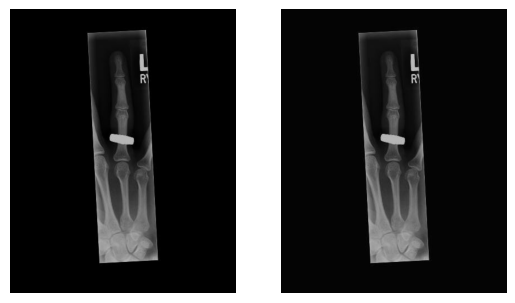

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\extra_low_brightness\image1_4632_png.rf.c05f7817e3841ab41364ef6d49c5f881.jpg
Transformed - entropy_group_1 - extra_low_brightness - image1_4632_png.rf.c05f7817e3841ab41364ef6d49c5f881.jpg


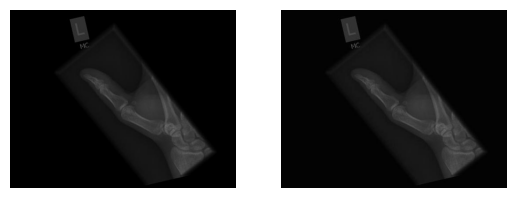

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\extra_low_brightness\image1_474_png.rf.2aad04023d6b08a9ef25ec3a5bbb8da8.jpg
Transformed - entropy_group_1 - extra_low_brightness - image1_474_png.rf.2aad04023d6b08a9ef25ec3a5bbb8da8.jpg


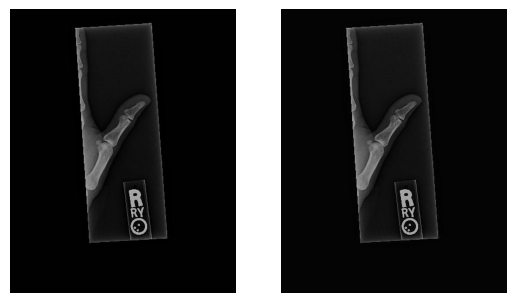

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\extra_low_brightness\image1_494_png.rf.441954c79593f504d8c8a9117a8eafb1.jpg
Transformed - entropy_group_1 - extra_low_brightness - image1_494_png.rf.441954c79593f504d8c8a9117a8eafb1.jpg


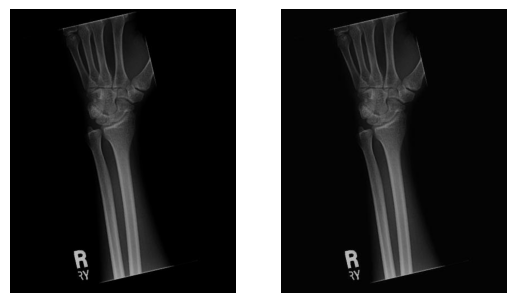

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\extra_low_brightness\image1_353_png.rf.4850e9bce6be10ced3976d35fdad70a6.jpg
Transformed - entropy_group_1 - extra_low_brightness - image1_353_png.rf.4850e9bce6be10ced3976d35fdad70a6.jpg


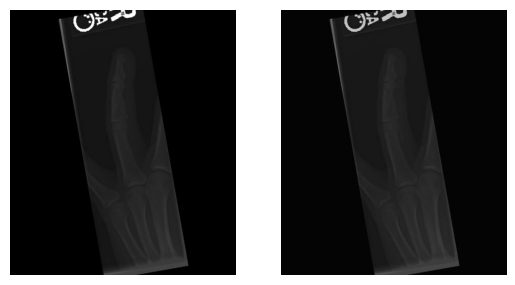

No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\high_brightness
No more images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\low_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\low_brightness\image1_94_png.rf.c791ab340e429f0a46390803fbebb23e.jpg
Transformed - entropy_group_1 - low_brightness - image1_94_png.rf.c791ab340e429f0a46390803fbebb23e.jpg


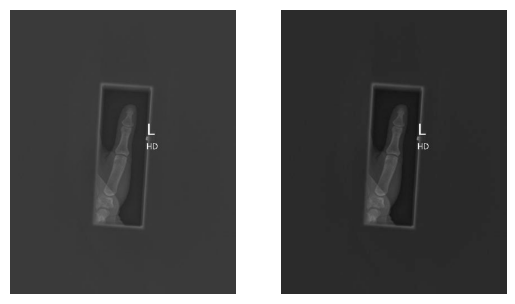

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\low_brightness\image1_94_png.rf.cac5e1aa9ae176c41817677a5622a88d.jpg
Transformed - entropy_group_1 - low_brightness - image1_94_png.rf.cac5e1aa9ae176c41817677a5622a88d.jpg


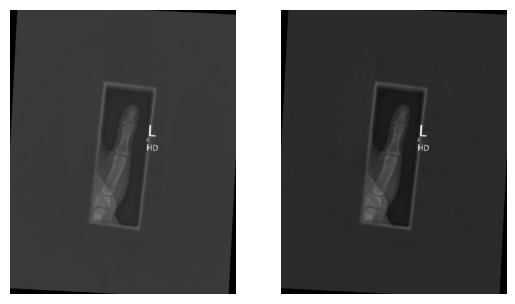

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\low_brightness\image1_599_png.rf.2f499ca9a1457b93d92437d9c449fe1a.jpg
Transformed - entropy_group_1 - low_brightness - image1_599_png.rf.2f499ca9a1457b93d92437d9c449fe1a.jpg


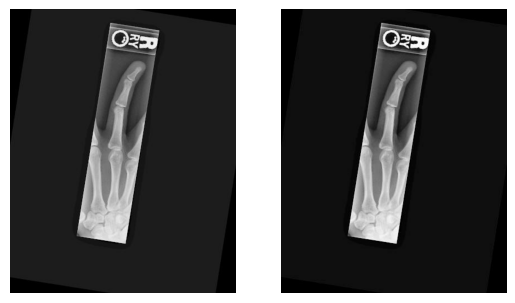

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\low_brightness\image1_94_png.rf.6c1bb904d2dabb641a0592c979c86159.jpg
Transformed - entropy_group_1 - low_brightness - image1_94_png.rf.6c1bb904d2dabb641a0592c979c86159.jpg


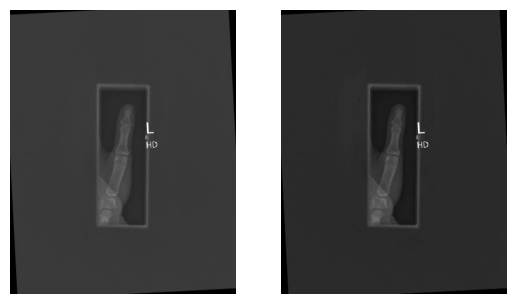

No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\medium_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_dark_brightness\image2_1151_png.rf.1221da48367cb290068f90f3204f64d1.jpg
Transformed - entropy_group_1 - very_dark_brightness - image2_1151_png.rf.1221da48367cb290068f90f3204f64d1.jpg


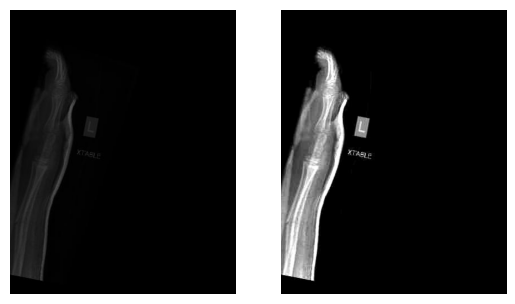

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_dark_brightness\image1_286_png.rf.bf08374ec84aff2e218cd0475eae6cfd.jpg
Transformed - entropy_group_1 - very_dark_brightness - image1_286_png.rf.bf08374ec84aff2e218cd0475eae6cfd.jpg


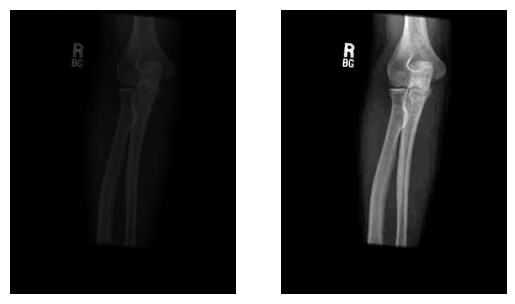

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_dark_brightness\image1_499_png.rf.bc1ae7e4e437826bb5b1014fe8cc1dbb.jpg
Transformed - entropy_group_1 - very_dark_brightness - image1_499_png.rf.bc1ae7e4e437826bb5b1014fe8cc1dbb.jpg


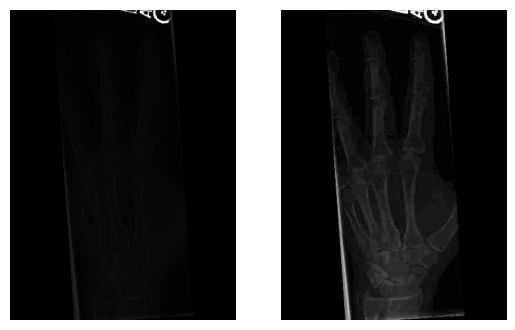

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_dark_brightness\image2_368_png.rf.8e8a959340338d25107e4e382b5cd77c.jpg
Transformed - entropy_group_1 - very_dark_brightness - image2_368_png.rf.8e8a959340338d25107e4e382b5cd77c.jpg


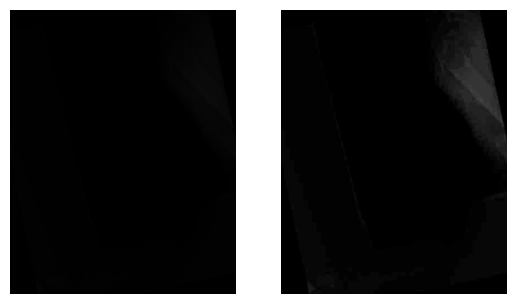

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_dark_brightness\image1_1082_png.rf.1016cf3f932355ac2d289a13668b97ab.jpg
Transformed - entropy_group_1 - very_dark_brightness - image1_1082_png.rf.1016cf3f932355ac2d289a13668b97ab.jpg


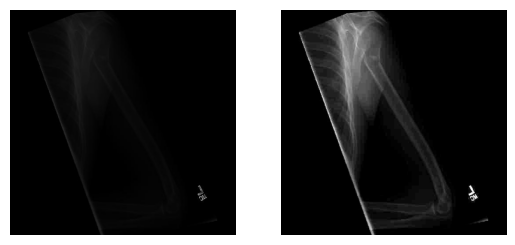

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_low_brightness\image1_558_png.rf.053622efb92a8ee1e2034d53a2129d69.jpg
Transformed - entropy_group_1 - very_low_brightness - image1_558_png.rf.053622efb92a8ee1e2034d53a2129d69.jpg


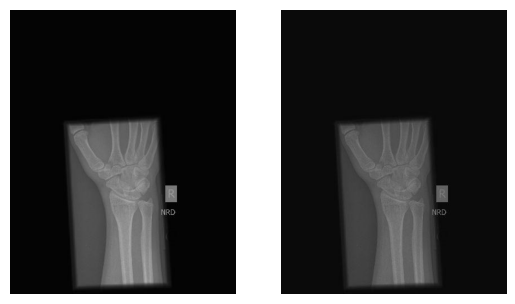

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_low_brightness\image1_3418_png.rf.badbdf51d45787fab08be9169b568c6b.jpg
Transformed - entropy_group_1 - very_low_brightness - image1_3418_png.rf.badbdf51d45787fab08be9169b568c6b.jpg


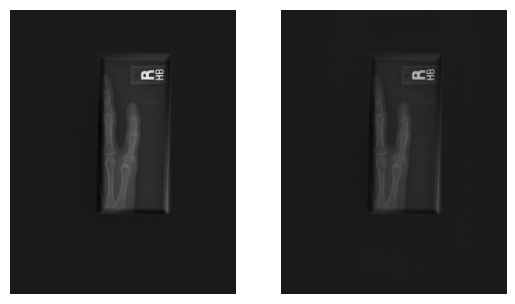

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_low_brightness\image1_194_png.rf.d716d03edb0f38f58d065818a203a07a.jpg
Transformed - entropy_group_1 - very_low_brightness - image1_194_png.rf.d716d03edb0f38f58d065818a203a07a.jpg


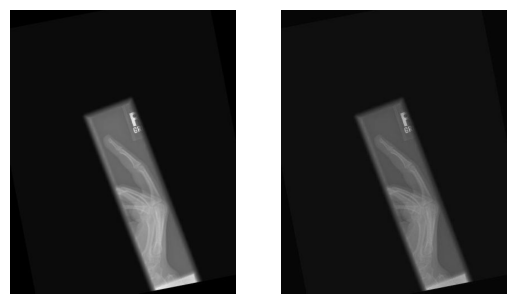

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_low_brightness\image1_836_png.rf.d515ea6c6a6e45cf783e75f7f86fecdf.jpg
Transformed - entropy_group_1 - very_low_brightness - image1_836_png.rf.d515ea6c6a6e45cf783e75f7f86fecdf.jpg


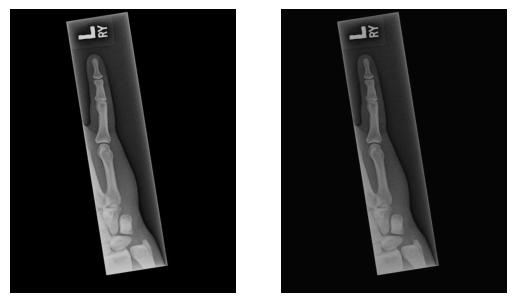

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_1\very_low_brightness\image1_432_png.rf.756907c065eca9cdab5a42a1206bf109.jpg
Transformed - entropy_group_1 - very_low_brightness - image1_432_png.rf.756907c065eca9cdab5a42a1206bf109.jpg


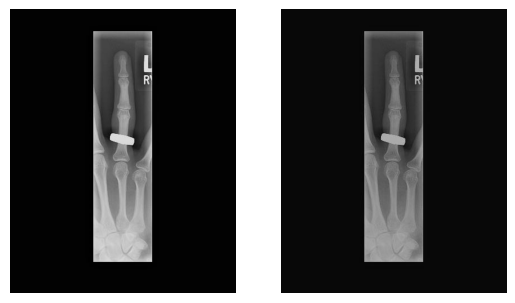

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\dark_brightness\image2_3_png.rf.4b89facc3d07b4a2284aa0d242b066b6.jpg
Transformed - entropy_group_2 - dark_brightness - image2_3_png.rf.4b89facc3d07b4a2284aa0d242b066b6.jpg


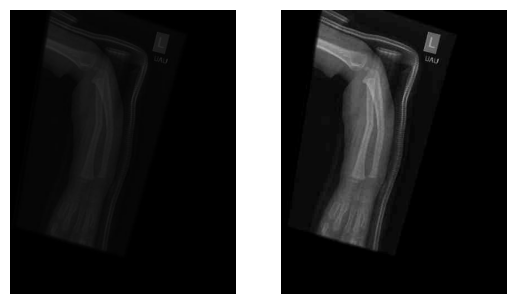

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\dark_brightness\image1_695_png.rf.6c57e2876aa9b7b366885dde9dd1cf3a.jpg
Transformed - entropy_group_2 - dark_brightness - image1_695_png.rf.6c57e2876aa9b7b366885dde9dd1cf3a.jpg


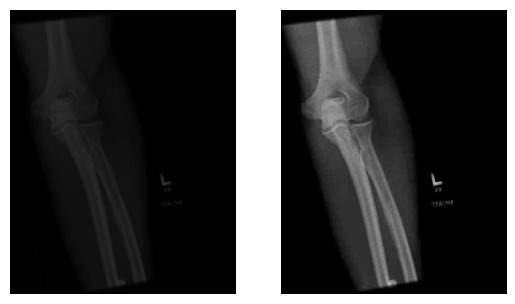

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\dark_brightness\image1_473_png.rf.80cb917a08b3eaa87d01b11d495b92ea.jpg
Transformed - entropy_group_2 - dark_brightness - image1_473_png.rf.80cb917a08b3eaa87d01b11d495b92ea.jpg


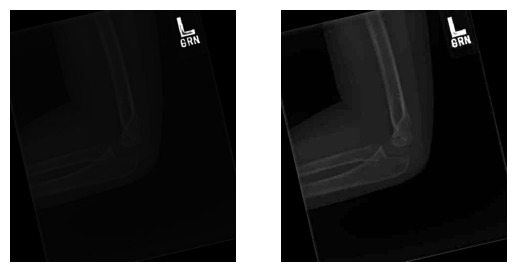

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\dark_brightness\image2_680_png.rf.6edcb1edebcfd88fe6601f59531e454f.jpg
Transformed - entropy_group_2 - dark_brightness - image2_680_png.rf.6edcb1edebcfd88fe6601f59531e454f.jpg


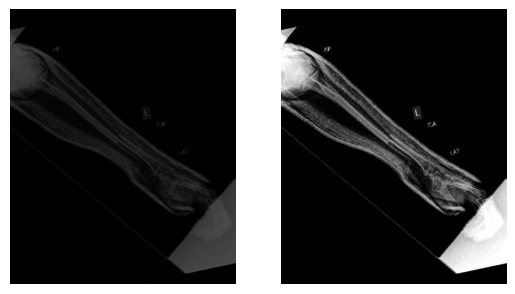

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\dark_brightness\image1_136_png.rf.95a7358f4921c6b5a16856962dbf4f01.jpg
Transformed - entropy_group_2 - dark_brightness - image1_136_png.rf.95a7358f4921c6b5a16856962dbf4f01.jpg


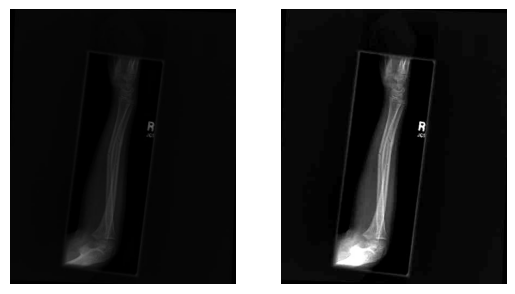

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\extra_low_brightness\image1_125_png.rf.e71b48e9c8eca25debd66dd5a3a77f33.jpg
Transformed - entropy_group_2 - extra_low_brightness - image1_125_png.rf.e71b48e9c8eca25debd66dd5a3a77f33.jpg


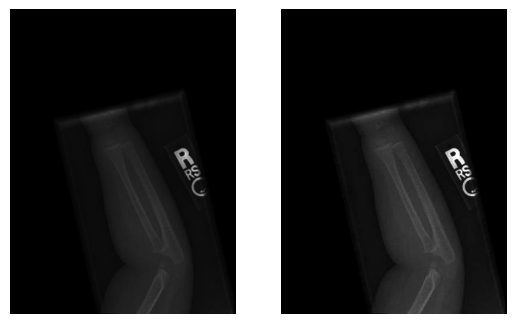

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\extra_low_brightness\image2_231_png.rf.3253a3fb814db0ff10c645b21eab2a08.jpg
Transformed - entropy_group_2 - extra_low_brightness - image2_231_png.rf.3253a3fb814db0ff10c645b21eab2a08.jpg


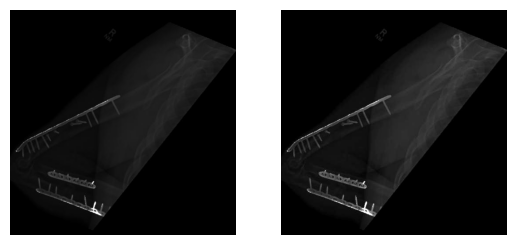

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\extra_low_brightness\image1_1703_png.rf.a2b0c6d47afd50867650de576a1bcb4a.jpg
Transformed - entropy_group_2 - extra_low_brightness - image1_1703_png.rf.a2b0c6d47afd50867650de576a1bcb4a.jpg


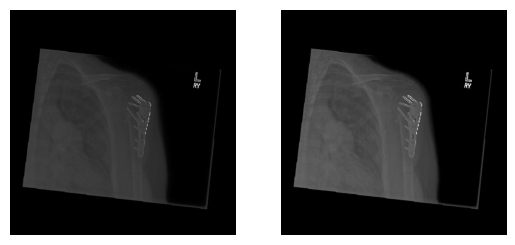

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\extra_low_brightness\image2_231_png.rf.195f1bcc776159e3b8d43eaa79b724a9.jpg
Transformed - entropy_group_2 - extra_low_brightness - image2_231_png.rf.195f1bcc776159e3b8d43eaa79b724a9.jpg


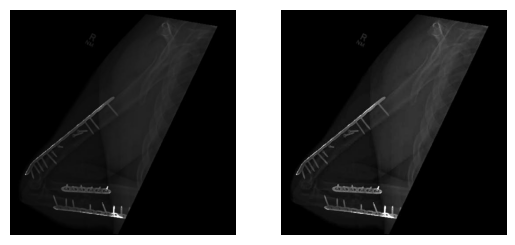

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\extra_low_brightness\image2_787_png.rf.c78cc060908dcc03e0005a922a004674.jpg
Transformed - entropy_group_2 - extra_low_brightness - image2_787_png.rf.c78cc060908dcc03e0005a922a004674.jpg


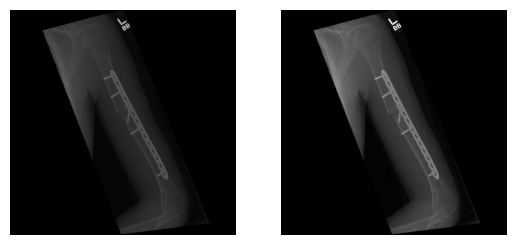

No more images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\high_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\high_brightness\image1_404_png.rf.e5aa8fe0ff4c322fe4832dd277c787d6.jpg
Transformed - entropy_group_2 - high_brightness - image1_404_png.rf.e5aa8fe0ff4c322fe4832dd277c787d6.jpg


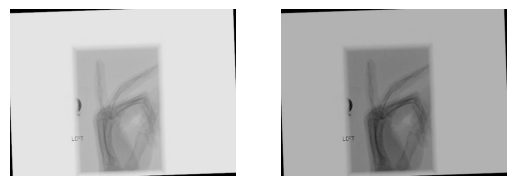

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\low_brightness\image1_1103_png.rf.a08a8845949f61ee80002ab93a9fc639.jpg
Transformed - entropy_group_2 - low_brightness - image1_1103_png.rf.a08a8845949f61ee80002ab93a9fc639.jpg


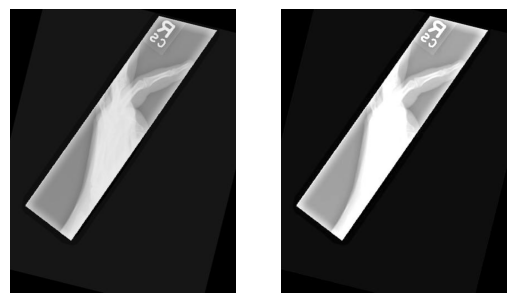

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\low_brightness\image1_187_png.rf.69881f0b3b1e3760463354fff21601f6.jpg
Transformed - entropy_group_2 - low_brightness - image1_187_png.rf.69881f0b3b1e3760463354fff21601f6.jpg


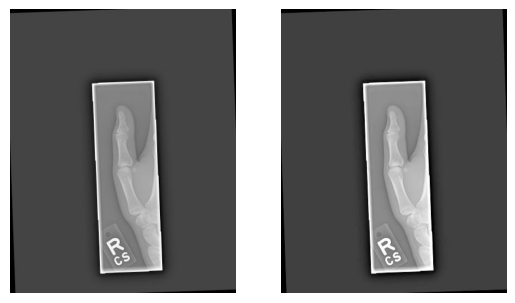

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\low_brightness\image1_4605_png.rf.fb3fcf350d4d34027e3838f641b5528b.jpg
Transformed - entropy_group_2 - low_brightness - image1_4605_png.rf.fb3fcf350d4d34027e3838f641b5528b.jpg


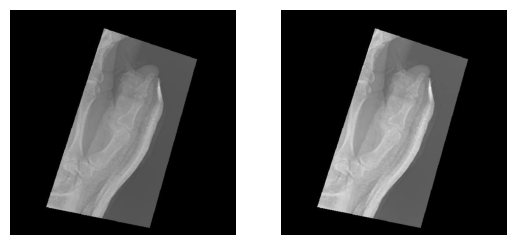

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\low_brightness\image1_1081_png.rf.7a7b641620f6483f4cfc2e5adce4ace3.jpg
Transformed - entropy_group_2 - low_brightness - image1_1081_png.rf.7a7b641620f6483f4cfc2e5adce4ace3.jpg


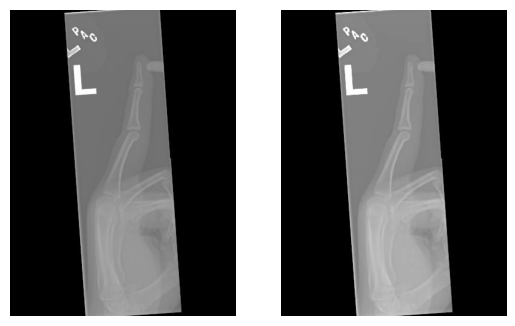

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\low_brightness\image1_187_png.rf.cb4e95293740fb3696f3305dac24c2ed.jpg
Transformed - entropy_group_2 - low_brightness - image1_187_png.rf.cb4e95293740fb3696f3305dac24c2ed.jpg


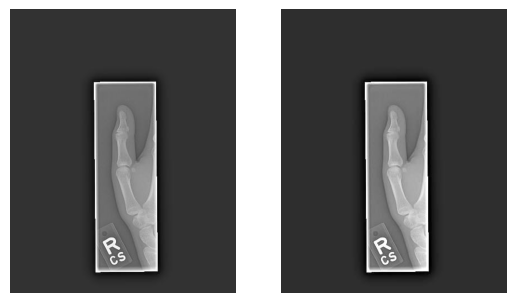

No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\medium_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_dark_brightness\image2_677_png.rf.6e98ff50e5048fc6a3ca4a2a7b4145e9.jpg
Transformed - entropy_group_2 - very_dark_brightness - image2_677_png.rf.6e98ff50e5048fc6a3ca4a2a7b4145e9.jpg


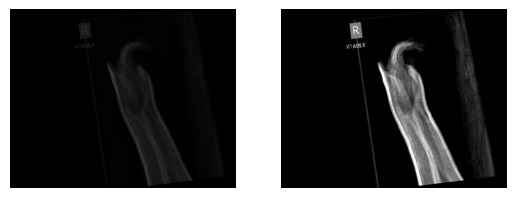

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_dark_brightness\image1_415_png.rf.57a36096a270f6717639896c95443b50.jpg
Transformed - entropy_group_2 - very_dark_brightness - image1_415_png.rf.57a36096a270f6717639896c95443b50.jpg


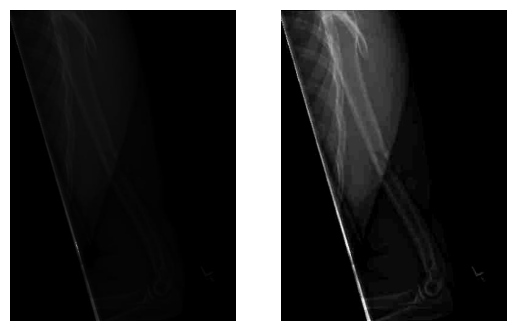

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_dark_brightness\image1_850_png.rf.acd779d2de6d371591417d986d0c6449.jpg
Transformed - entropy_group_2 - very_dark_brightness - image1_850_png.rf.acd779d2de6d371591417d986d0c6449.jpg


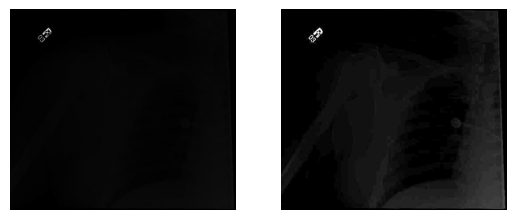

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_dark_brightness\image1_288_png.rf.4f74fd9cca8298c0b0aaf6eced4d4940.jpg
Transformed - entropy_group_2 - very_dark_brightness - image1_288_png.rf.4f74fd9cca8298c0b0aaf6eced4d4940.jpg


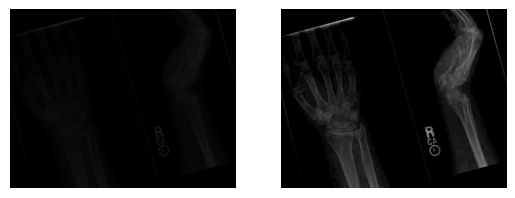

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_dark_brightness\image1_779_png.rf.5866c009b5ef16defe1c32bb19a709bd.jpg
Transformed - entropy_group_2 - very_dark_brightness - image1_779_png.rf.5866c009b5ef16defe1c32bb19a709bd.jpg


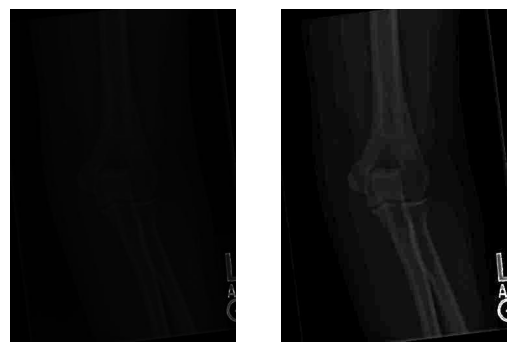

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_low_brightness\image1_426_png.rf.8cefa4fa7a0d44b4352aa483696f6f2f.jpg
Transformed - entropy_group_2 - very_low_brightness - image1_426_png.rf.8cefa4fa7a0d44b4352aa483696f6f2f.jpg


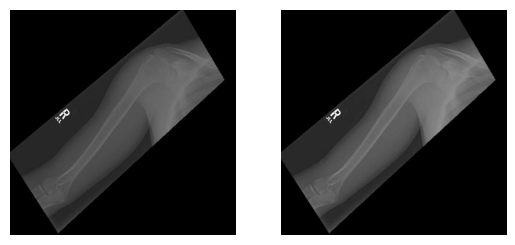

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_low_brightness\image1_1893_png.rf.c7fec057beb3ab6c82d88391053cf6f6.jpg
Transformed - entropy_group_2 - very_low_brightness - image1_1893_png.rf.c7fec057beb3ab6c82d88391053cf6f6.jpg


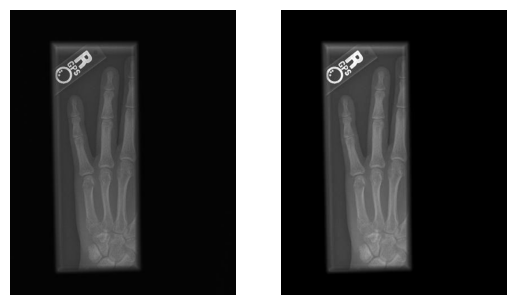

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_low_brightness\image1_19_png.rf.aae4ce952de60e2ee89161a25de90e56.jpg
Transformed - entropy_group_2 - very_low_brightness - image1_19_png.rf.aae4ce952de60e2ee89161a25de90e56.jpg


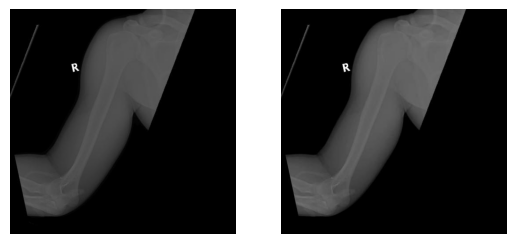

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_low_brightness\image1_280_png.rf.0ee0842e0598ecf95a37a40cb27a9293.jpg
Transformed - entropy_group_2 - very_low_brightness - image1_280_png.rf.0ee0842e0598ecf95a37a40cb27a9293.jpg


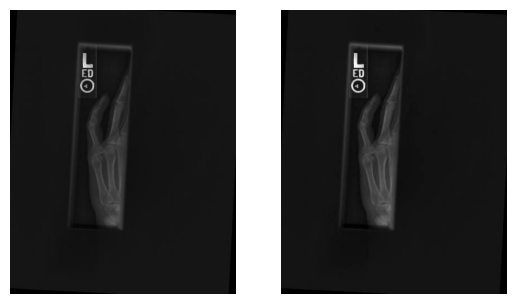

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_2\very_low_brightness\image1_45_png.rf.85d8054bc4130be6ecc18de3ae5748a1.jpg
Transformed - entropy_group_2 - very_low_brightness - image1_45_png.rf.85d8054bc4130be6ecc18de3ae5748a1.jpg


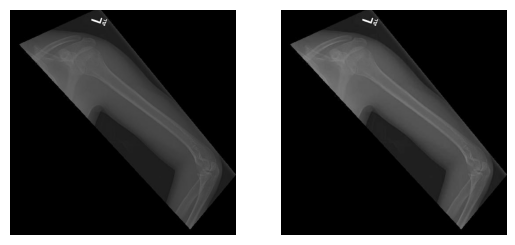

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\dark_brightness\image1_1094_png.rf.f402d33fff5ee2ce03ed8459ed0426d8.jpg
Transformed - entropy_group_3 - dark_brightness - image1_1094_png.rf.f402d33fff5ee2ce03ed8459ed0426d8.jpg


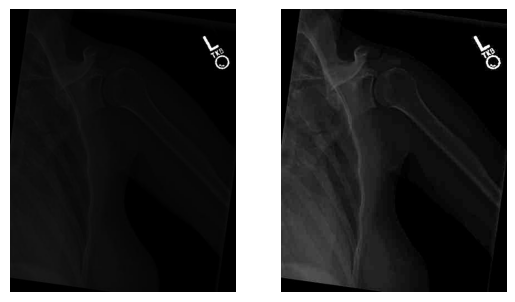

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\dark_brightness\image2_1394_png.rf.27b57d92022f238873a67c19b1cbf0d9.jpg
Transformed - entropy_group_3 - dark_brightness - image2_1394_png.rf.27b57d92022f238873a67c19b1cbf0d9.jpg


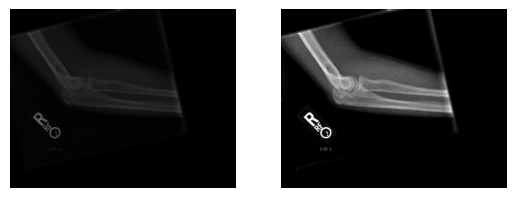

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\dark_brightness\image2_338_png.rf.ab9c2d12a01b1f6db7e619f9b79f3d63.jpg
Transformed - entropy_group_3 - dark_brightness - image2_338_png.rf.ab9c2d12a01b1f6db7e619f9b79f3d63.jpg


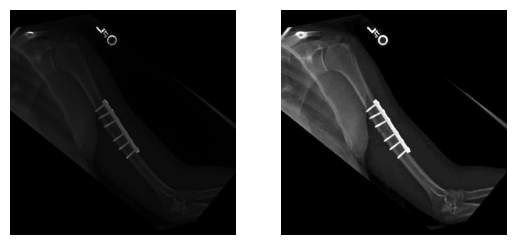

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\dark_brightness\image1_185_png.rf.c5b291c7278922547594dc9abdfcdf91.jpg
Transformed - entropy_group_3 - dark_brightness - image1_185_png.rf.c5b291c7278922547594dc9abdfcdf91.jpg


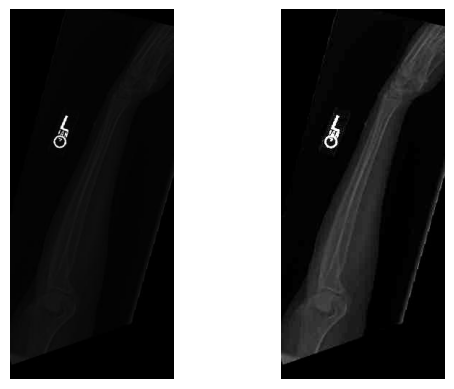

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\dark_brightness\image1_32_png.rf.8661f4d2c24b7f02845e3715dfb71135.jpg
Transformed - entropy_group_3 - dark_brightness - image1_32_png.rf.8661f4d2c24b7f02845e3715dfb71135.jpg


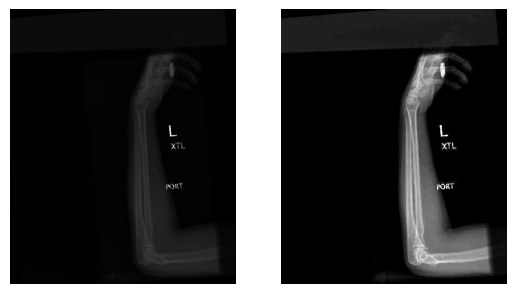

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\extra_low_brightness\image1_376_png.rf.cc7dc108ec6db52da50bd7e902713305.jpg
Transformed - entropy_group_3 - extra_low_brightness - image1_376_png.rf.cc7dc108ec6db52da50bd7e902713305.jpg


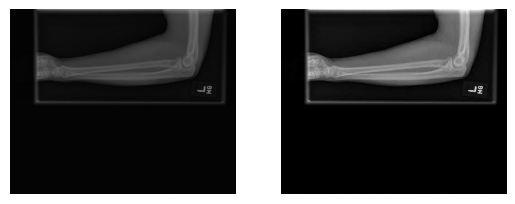

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\extra_low_brightness\image1_1265_png.rf.25edd9c6341036a44ee7c423637042f9.jpg
Transformed - entropy_group_3 - extra_low_brightness - image1_1265_png.rf.25edd9c6341036a44ee7c423637042f9.jpg


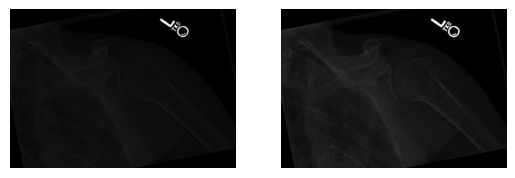

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\extra_low_brightness\image1_7973_png.rf.368cc6022c017f59ad3c2df21ce3bb6b.jpg
Transformed - entropy_group_3 - extra_low_brightness - image1_7973_png.rf.368cc6022c017f59ad3c2df21ce3bb6b.jpg


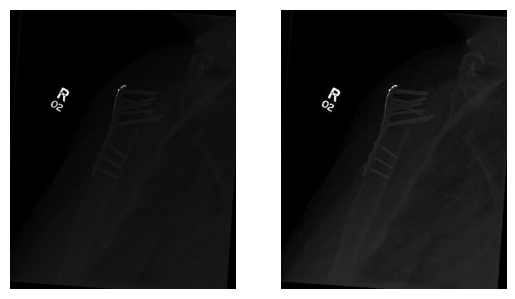

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\extra_low_brightness\image1_962_png.rf.1d5f8fba074c93f021043067b89d38df.jpg
Transformed - entropy_group_3 - extra_low_brightness - image1_962_png.rf.1d5f8fba074c93f021043067b89d38df.jpg


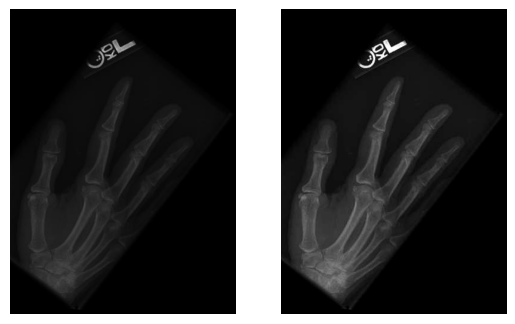

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\extra_low_brightness\image1_269_png.rf.e92f622ff2c8ac458612d956dd9b2dd4.jpg
Transformed - entropy_group_3 - extra_low_brightness - image1_269_png.rf.e92f622ff2c8ac458612d956dd9b2dd4.jpg


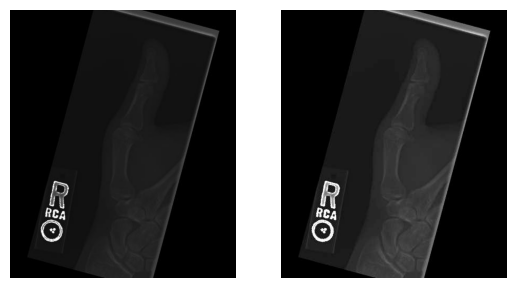

No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\high_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\low_brightness\image2_25_png.rf.22be0a6eceefc6bb211fe0b515dd4930.jpg
Transformed - entropy_group_3 - low_brightness - image2_25_png.rf.22be0a6eceefc6bb211fe0b515dd4930.jpg


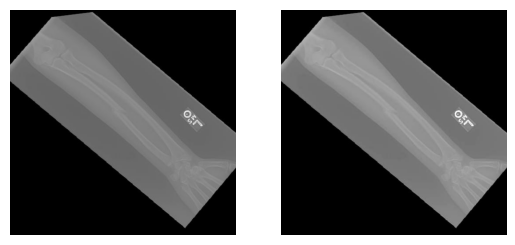

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\low_brightness\image1_3133_png.rf.6fdd204cabe7f84fb2173d91c4032a3a.jpg
Transformed - entropy_group_3 - low_brightness - image1_3133_png.rf.6fdd204cabe7f84fb2173d91c4032a3a.jpg


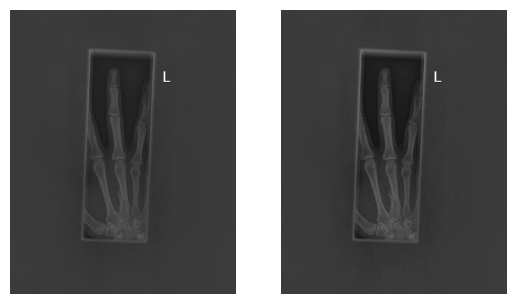

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\low_brightness\image1_1447_png.rf.708f77c92737077936f2bd63a7736134.jpg
Transformed - entropy_group_3 - low_brightness - image1_1447_png.rf.708f77c92737077936f2bd63a7736134.jpg


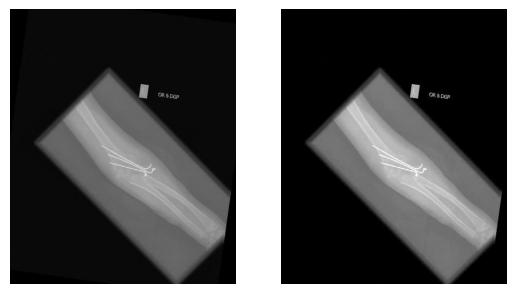

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\low_brightness\image1_306_png.rf.9c5b902b92c40ad7c75d92b95bf4a129.jpg
Transformed - entropy_group_3 - low_brightness - image1_306_png.rf.9c5b902b92c40ad7c75d92b95bf4a129.jpg


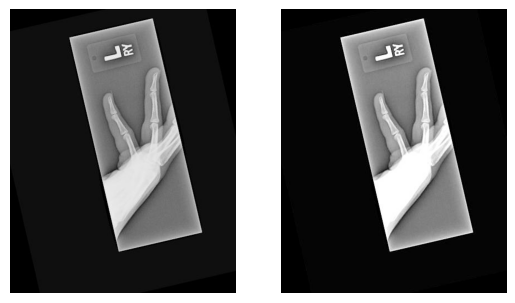

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\low_brightness\image1_174_png.rf.459ab6811610ac81868be7c2e32e0cbd.jpg
Transformed - entropy_group_3 - low_brightness - image1_174_png.rf.459ab6811610ac81868be7c2e32e0cbd.jpg


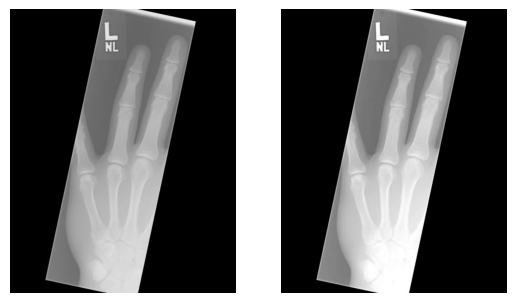

No more images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\medium_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\medium_brightness\image1_1048_png.rf.57884b1ff70a4ed44e77b44d166387fd.jpg
Transformed - entropy_group_3 - medium_brightness - image1_1048_png.rf.57884b1ff70a4ed44e77b44d166387fd.jpg


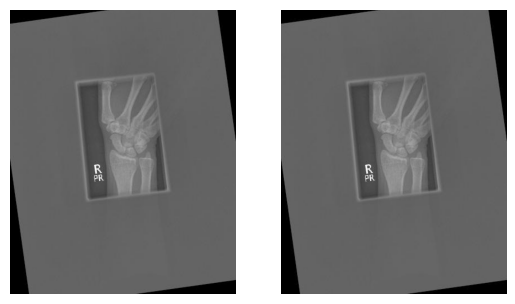

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\medium_brightness\image1_404_png.rf.a1292dd59f3800ad268d31c89cd955eb.jpg
Transformed - entropy_group_3 - medium_brightness - image1_404_png.rf.a1292dd59f3800ad268d31c89cd955eb.jpg


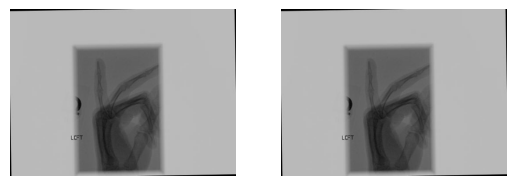

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\medium_brightness\image1_404_png.rf.4c0e62547ec64e936cf99baf0f421817.jpg
Transformed - entropy_group_3 - medium_brightness - image1_404_png.rf.4c0e62547ec64e936cf99baf0f421817.jpg


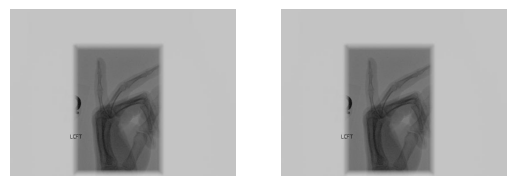

No more images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_dark_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_dark_brightness\image1_2607_png.rf.c850e8afd598f91520f3a950af305546.jpg
Transformed - entropy_group_3 - very_dark_brightness - image1_2607_png.rf.c850e8afd598f91520f3a950af305546.jpg


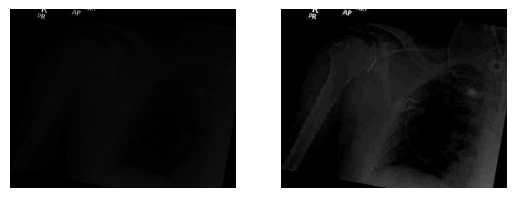

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_low_brightness\image1_109_png.rf.16f53a0df738944f669a1562ec5243ef.jpg
Transformed - entropy_group_3 - very_low_brightness - image1_109_png.rf.16f53a0df738944f669a1562ec5243ef.jpg


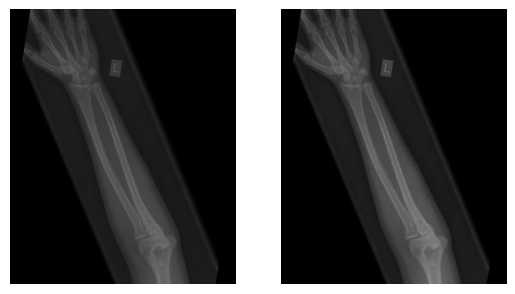

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_low_brightness\image1_367_png.rf.ef4efcebca50c91d7f9b6042bada2cd0.jpg
Transformed - entropy_group_3 - very_low_brightness - image1_367_png.rf.ef4efcebca50c91d7f9b6042bada2cd0.jpg


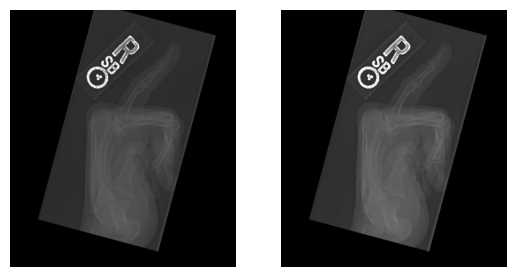

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_low_brightness\image1_12_png.rf.d5eb41521be0b98a2b6aca4015f53b16.jpg
Transformed - entropy_group_3 - very_low_brightness - image1_12_png.rf.d5eb41521be0b98a2b6aca4015f53b16.jpg


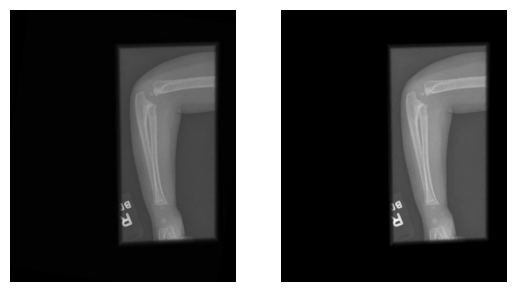

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_low_brightness\image1_4699_png.rf.926aca77bc9d006c27b65fbd50632253.jpg
Transformed - entropy_group_3 - very_low_brightness - image1_4699_png.rf.926aca77bc9d006c27b65fbd50632253.jpg


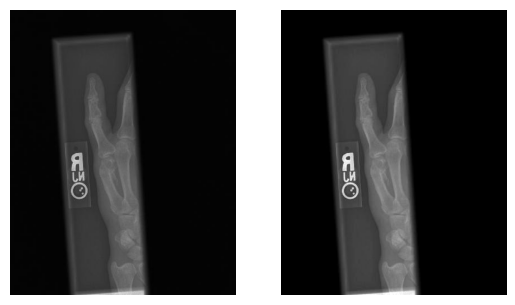

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_3\very_low_brightness\image1_117_png.rf.eb80e5b858d48b62cd64ae0cf48f5ac2.jpg
Transformed - entropy_group_3 - very_low_brightness - image1_117_png.rf.eb80e5b858d48b62cd64ae0cf48f5ac2.jpg


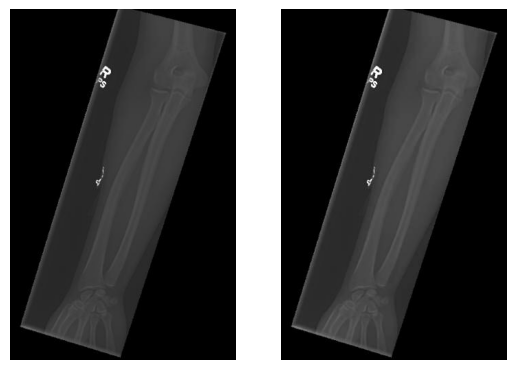

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\dark_brightness\image1_287_png.rf.f5609454a98ed7c98248a1f09fc19764.jpg
Transformed - entropy_group_4 - dark_brightness - image1_287_png.rf.f5609454a98ed7c98248a1f09fc19764.jpg


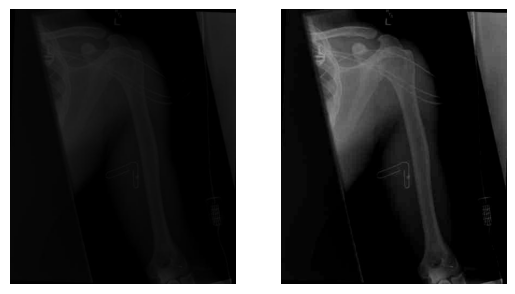

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\dark_brightness\image1_4095_png.rf.fd64149bf1c7aff2bc4ccda23c573034.jpg
Transformed - entropy_group_4 - dark_brightness - image1_4095_png.rf.fd64149bf1c7aff2bc4ccda23c573034.jpg


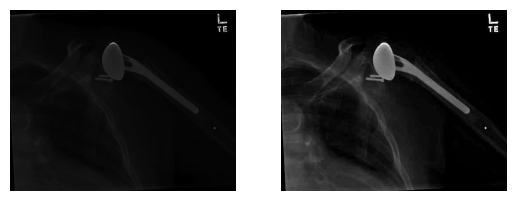

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\dark_brightness\image1_1234_png.rf.d331c5737d6c95ffed28360d725d305c.jpg
Transformed - entropy_group_4 - dark_brightness - image1_1234_png.rf.d331c5737d6c95ffed28360d725d305c.jpg


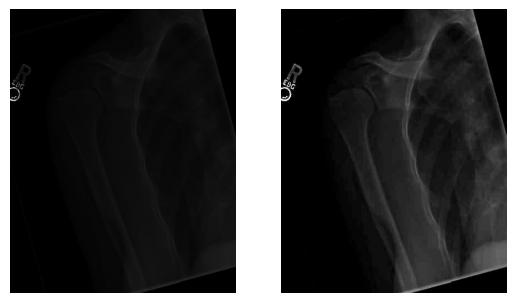

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\dark_brightness\image1_31_png.rf.bdf246c7babb32ce0b93a94b55c990e3.jpg
Transformed - entropy_group_4 - dark_brightness - image1_31_png.rf.bdf246c7babb32ce0b93a94b55c990e3.jpg


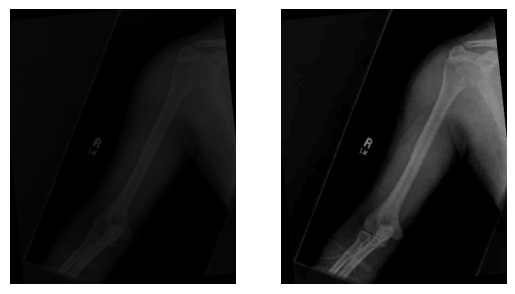

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\dark_brightness\image1_156_png.rf.9aafb1c56f306aaa6cf6384fbb8bda9f.jpg
Transformed - entropy_group_4 - dark_brightness - image1_156_png.rf.9aafb1c56f306aaa6cf6384fbb8bda9f.jpg


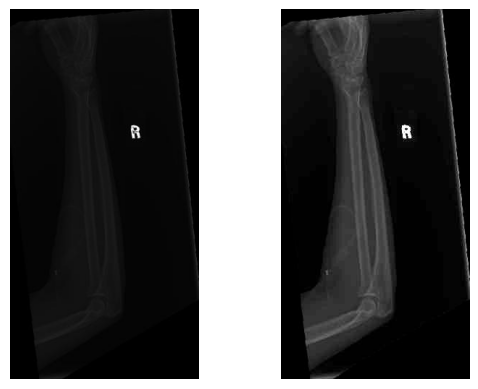

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\extra_low_brightness\image1_84_png.rf.051c824db9f123b0a253d4c2456e7522.jpg
Transformed - entropy_group_4 - extra_low_brightness - image1_84_png.rf.051c824db9f123b0a253d4c2456e7522.jpg


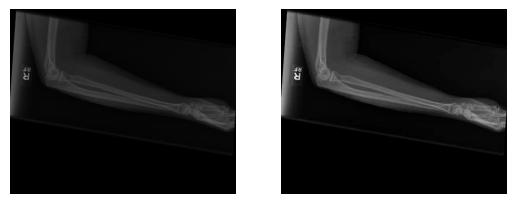

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\extra_low_brightness\image1_662_png.rf.f480502d7baa13d178a907819790fcf5.jpg
Transformed - entropy_group_4 - extra_low_brightness - image1_662_png.rf.f480502d7baa13d178a907819790fcf5.jpg


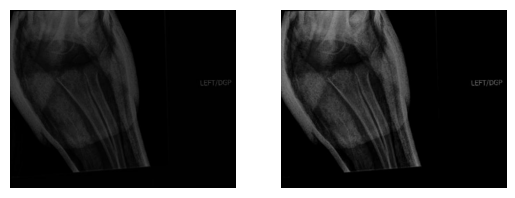

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\extra_low_brightness\image1_59_png.rf.87e06992b0ea03e036b1bf1ccc1a8d87.jpg
Transformed - entropy_group_4 - extra_low_brightness - image1_59_png.rf.87e06992b0ea03e036b1bf1ccc1a8d87.jpg


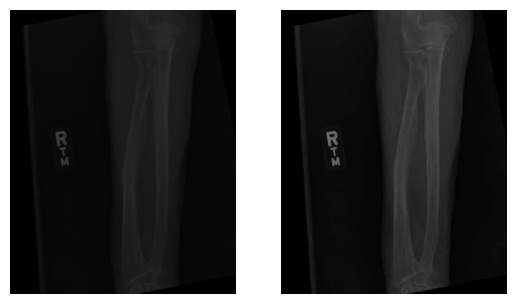

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\extra_low_brightness\image1_641_png.rf.9854cff990ecc40db2bd415207e0e82f.jpg
Transformed - entropy_group_4 - extra_low_brightness - image1_641_png.rf.9854cff990ecc40db2bd415207e0e82f.jpg


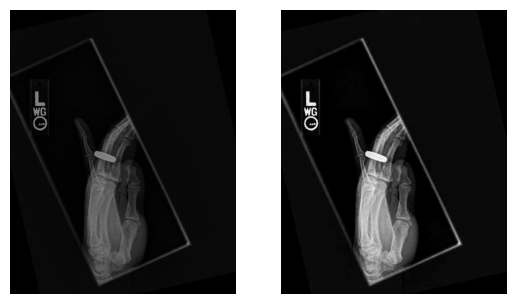

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\extra_low_brightness\image1_383_png.rf.0df3bddab531201fb746523991b46b7d.jpg
Transformed - entropy_group_4 - extra_low_brightness - image1_383_png.rf.0df3bddab531201fb746523991b46b7d.jpg


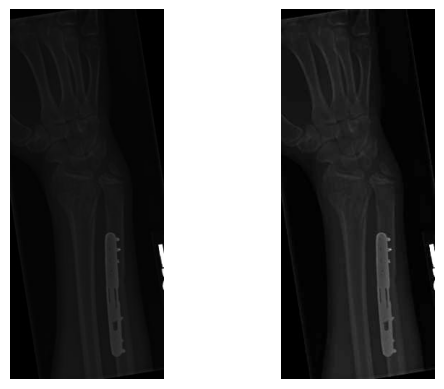

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\high_brightness\image2_2923_png.rf.fea447fcbf763a3d4560d4954a662bf2.jpg
Transformed - entropy_group_4 - high_brightness - image2_2923_png.rf.fea447fcbf763a3d4560d4954a662bf2.jpg


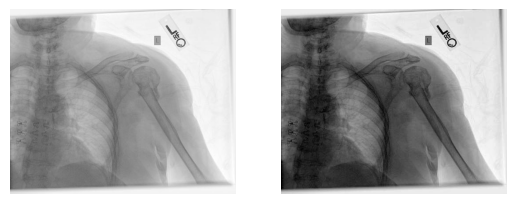

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\high_brightness\image1_640_png.rf.8ba9be52ab6128b893e1e559ca6ecb1b.jpg
Transformed - entropy_group_4 - high_brightness - image1_640_png.rf.8ba9be52ab6128b893e1e559ca6ecb1b.jpg


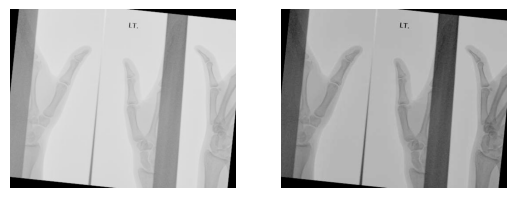

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\high_brightness\image2_1211_png.rf.1a8cddc12a52500ce16c74a20ae281f1.jpg
Transformed - entropy_group_4 - high_brightness - image2_1211_png.rf.1a8cddc12a52500ce16c74a20ae281f1.jpg


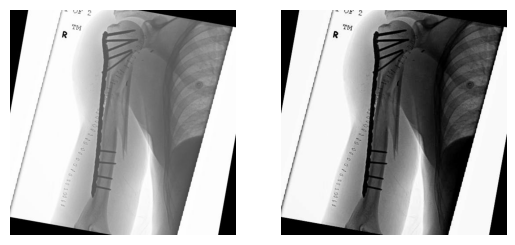

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\high_brightness\image1_541_png.rf.073b8481dce4e8a4c530fbb3dc779872.jpg
Transformed - entropy_group_4 - high_brightness - image1_541_png.rf.073b8481dce4e8a4c530fbb3dc779872.jpg


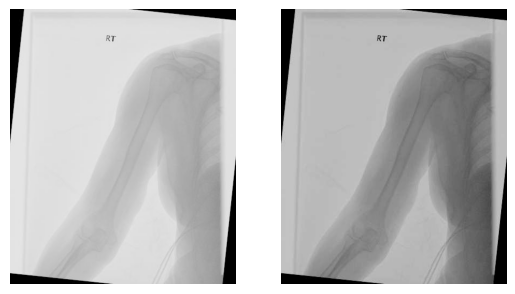

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\high_brightness\image1_631_png.rf.9177d476cea6b8a8db2ffc89dc5708e8.jpg
Transformed - entropy_group_4 - high_brightness - image1_631_png.rf.9177d476cea6b8a8db2ffc89dc5708e8.jpg


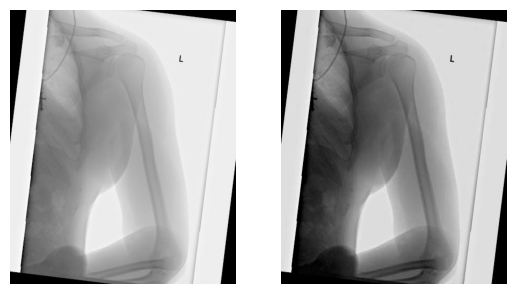

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\low_brightness\image2_685_png.rf.51fa666856fa8143191d5e98715dea54.jpg
Transformed - entropy_group_4 - low_brightness - image2_685_png.rf.51fa666856fa8143191d5e98715dea54.jpg


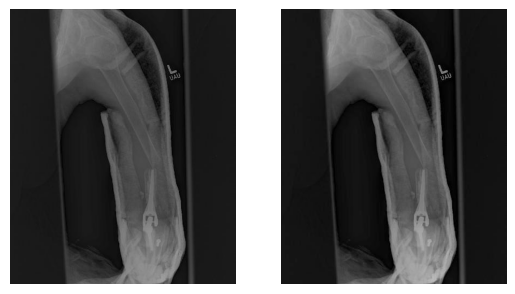

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\low_brightness\image1_186_png.rf.75804f1a63d0f30536736fd96b91841c.jpg
Transformed - entropy_group_4 - low_brightness - image1_186_png.rf.75804f1a63d0f30536736fd96b91841c.jpg


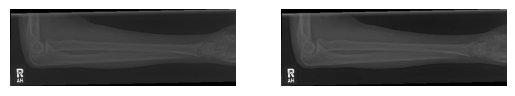

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\low_brightness\image2_1695_png.rf.0e8b7abdcc2d9b7a4126cfa4bc322e72.jpg
Transformed - entropy_group_4 - low_brightness - image2_1695_png.rf.0e8b7abdcc2d9b7a4126cfa4bc322e72.jpg


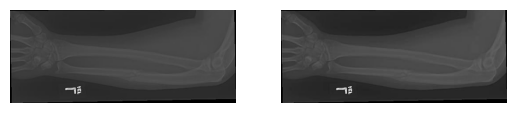

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\low_brightness\image1_12_png.rf.1df3cfddec464ffc5edefd65ca587c4c.jpg
Transformed - entropy_group_4 - low_brightness - image1_12_png.rf.1df3cfddec464ffc5edefd65ca587c4c.jpg


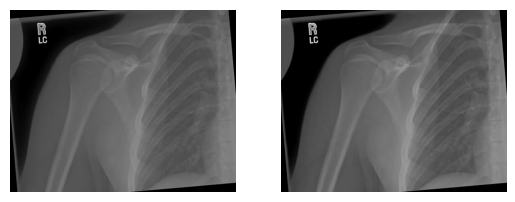

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\low_brightness\image1_1140_png.rf.0a8042912a284affb713b2891c0cb8b8.jpg
Transformed - entropy_group_4 - low_brightness - image1_1140_png.rf.0a8042912a284affb713b2891c0cb8b8.jpg


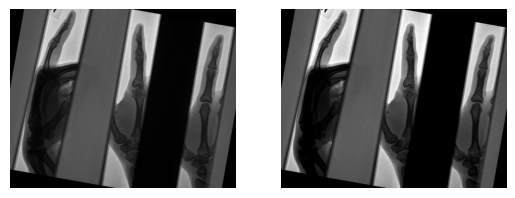

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\medium_brightness\image1_385_png.rf.1530592092a7e7ea13599cec00a2523f.jpg
Transformed - entropy_group_4 - medium_brightness - image1_385_png.rf.1530592092a7e7ea13599cec00a2523f.jpg


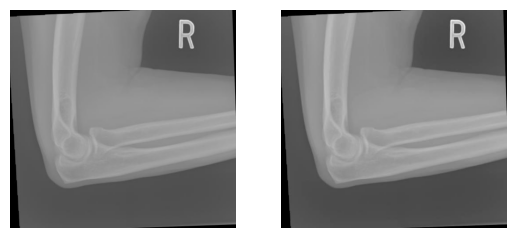

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\medium_brightness\image1_1453_png.rf.6f8df5bea4158e357b518c94fbc95caa.jpg
Transformed - entropy_group_4 - medium_brightness - image1_1453_png.rf.6f8df5bea4158e357b518c94fbc95caa.jpg


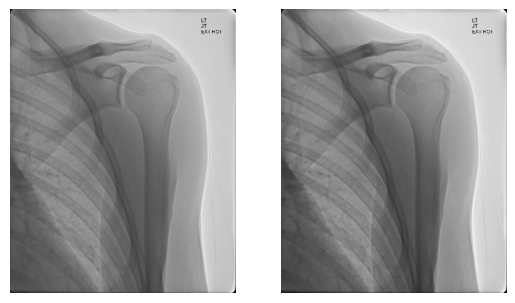

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\medium_brightness\image1_360_png.rf.b883a24d9eeac71c831a8142d8a2f053.jpg
Transformed - entropy_group_4 - medium_brightness - image1_360_png.rf.b883a24d9eeac71c831a8142d8a2f053.jpg


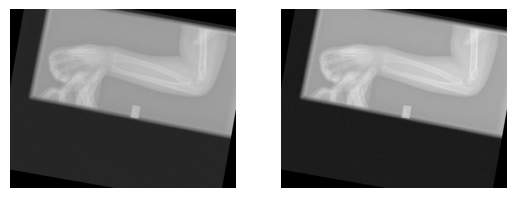

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\medium_brightness\image1_4244_png.rf.7c26a29d8d469e5498f3dc522b1b06ee.jpg
Transformed - entropy_group_4 - medium_brightness - image1_4244_png.rf.7c26a29d8d469e5498f3dc522b1b06ee.jpg


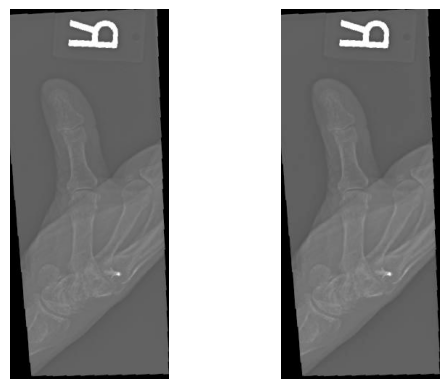

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\medium_brightness\image1_318_png.rf.7ebe4965a379bfeb260802b84a0890b9.jpg
Transformed - entropy_group_4 - medium_brightness - image1_318_png.rf.7ebe4965a379bfeb260802b84a0890b9.jpg


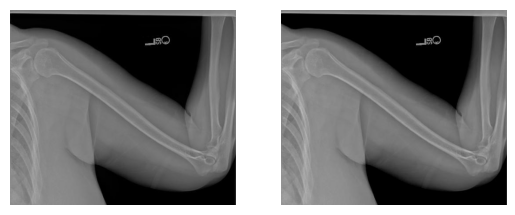

No images in folder C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\very_dark_brightness
Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\very_low_brightness\image1_274_png.rf.3971f63d3e4d374d3515f12e73f4e914.jpg
Transformed - entropy_group_4 - very_low_brightness - image1_274_png.rf.3971f63d3e4d374d3515f12e73f4e914.jpg


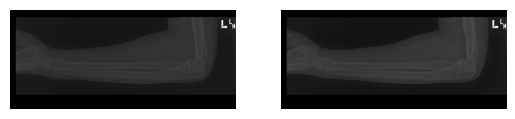

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\very_low_brightness\image2_1228_png.rf.16c99de7b17fa623afb6de3e425af853.jpg
Transformed - entropy_group_4 - very_low_brightness - image2_1228_png.rf.16c99de7b17fa623afb6de3e425af853.jpg


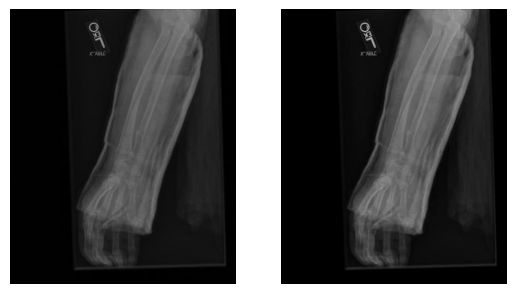

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\very_low_brightness\image1_282_png.rf.1aad57c7668ae69f22d7a85a805c94f9.jpg
Transformed - entropy_group_4 - very_low_brightness - image1_282_png.rf.1aad57c7668ae69f22d7a85a805c94f9.jpg


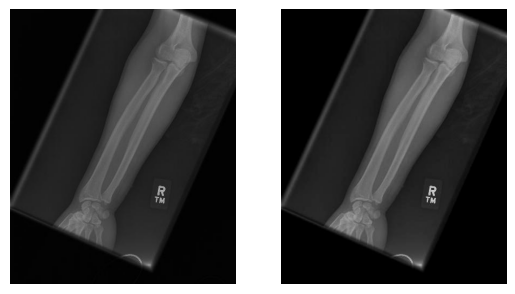

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\very_low_brightness\image1_647_png.rf.eec67bdeb396d8d6efd1e6b13f27b1fe.jpg
Transformed - entropy_group_4 - very_low_brightness - image1_647_png.rf.eec67bdeb396d8d6efd1e6b13f27b1fe.jpg


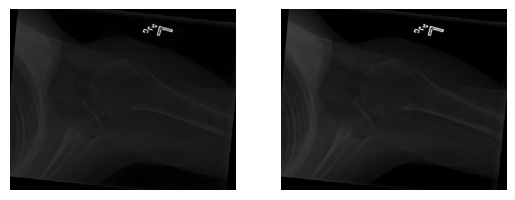

Original - C:\Users\Chris\Documents\Uni\Programm for AI\completed test\entropy_group_4\very_low_brightness\image1_141_png.rf.19b1953e56b0ea23673af26baabb7fca.jpg
Transformed - entropy_group_4 - very_low_brightness - image1_141_png.rf.19b1953e56b0ea23673af26baabb7fca.jpg


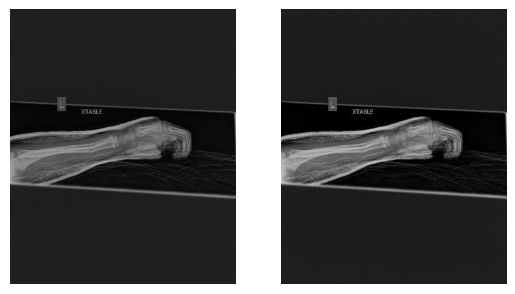

In [20]:
compare_images(base_dir_path, entropy_group_values)

Change resolution to 250x250 both maintaining and not maintaining asepct resolution

In [23]:

def resize_image(input_image_path, output_image_path, size):
    original_image = Image.open(input_image_path)
    resized_image = original_image.resize(size)
    draw = ImageDraw.Draw(resized_image)
    font = ImageFont.load_default()
    #draw.text((10, 10), f"Pixel Count: {resized_image.width * resized_image.height}", (255,255,255), font=font)
    resized_image.save(output_image_path)

def resize_image_maintain_aspect_ratio(input_image_path, output_image_path, size):
    original_image = Image.open(input_image_path)
    width, height = original_image.size
    max_size = max(width, height)
    scale = size / max_size
    new_width = int(width * scale)
    new_height = int(height * scale)
    resized_image = original_image.resize((new_width, new_height))
    draw = ImageDraw.Draw(resized_image)
    font = ImageFont.load_default()
    #draw.text((10, 10), f"Pixel Count: {resized_image.width * resized_image.height}", (255,255,255), font=font)
    resized_image.save(output_image_path)

def process_images(directory):
    categories = ['very_dark_brightness', 'dark_brightness', 'extra_low_brightness', 
                  'very_low_brightness', 'low_brightness', 'medium_brightness', 'high_brightness']

    for i in range(5):
        entropy_group_dir = os.path.join(directory, f'entropy_group_{i}')
        if os.path.exists(entropy_group_dir):
            for category in categories:
                category_dir = os.path.join(entropy_group_dir, category, 'edited_images')
                if os.path.exists(category_dir):
                    for resize_type in ['resized', 'resized_aspect_ratio']:
                        resize_dir = os.path.join(category_dir, resize_type)
                        if os.path.exists(resize_dir):
                            shutil.rmtree(resize_dir)
                        os.makedirs(resize_dir)

                    for filename in os.listdir(category_dir):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            resize_image(os.path.join(category_dir, filename), os.path.join(category_dir, 'resized', filename), (250, 250))
                            resize_image_maintain_aspect_ratio(os.path.join(category_dir, filename), os.path.join(category_dir, 'resized_aspect_ratio', filename), 250)

image_directory = script_dir
process_images(image_directory)

move resized imaged into the root/source folder

In [25]:
def copy_resized_images(source_directory, destination_directory):
    # Create directories in destination_directory for resized images and resized images maintaining aspect ratio
    resized_dir = os.path.join(destination_directory, 'all_resized')
    resized_aspect_ratio_dir = os.path.join(destination_directory, 'all_resized_aspect_ratio')
    if not os.path.exists(resized_dir):
        os.makedirs(resized_dir)
    if not os.path.exists(resized_aspect_ratio_dir):
        os.makedirs(resized_aspect_ratio_dir)

    # Walk through source_directory and copy all resized images and resized images maintaining aspect ratio to destination_directory
    for dirpath, dirnames, filenames in os.walk(source_directory):
        for filename in filenames:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                if 'resized' in dirpath and not 'resized_aspect_ratio' in dirpath:
                    shutil.copy(os.path.join(dirpath, filename), os.path.join(resized_dir, filename))
                elif 'resized_aspect_ratio' in dirpath:
                    shutil.copy(os.path.join(dirpath, filename), os.path.join(resized_aspect_ratio_dir, filename))

# Use the function
source_directory = script_dir
destination_directory = script_dir
copy_resized_images(source_directory, destination_directory)